# 2nd CMI-PB Prediction Challenge
## Team Advisor: Barry Grant, Jason Hsiao
## Team member: Peng Cheng, Javier Garcia, Brian Qian, Weikang Guan
## Part 2: Model Training

In [1]:
# Import necessary Python libraries.
import os  # Library for interacting with the operating system
import csv  # Library for handling CSV files
import warnings  # Library for issuing warning messages
import logging  # Library for logging messages
import numpy as np  # Library for numerical operations on large arrays and matrices
import pandas as pd  # Library for data manipulation and analysis
import matplotlib.pyplot as plt  # Library for creating visualizations
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, RobustScaler, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, LassoCV, SGDRegressor, BayesianRidge, ARDRegression, PassiveAggressiveRegressor, HuberRegressor, QuantileRegressor, TheilSenRegressor, PoissonRegressor
from sklearn.neighbors import RadiusNeighborsRegressor, KNeighborsRegressor
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel, RFE, f_regression, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
from joblib import dump
from math import sqrt  # Library for mathematical functions

# Configure warnings to ignore convergence warnings which might clutter output.
warnings.simplefilter('always', FitFailedWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore')

# Set pandas option to display all rows
pd.set_option('display.max_rows', None)

# Check if the directory for training results does not exist, then create it.
if not os.path.exists('training_result'):
    os.makedirs('training_result')

In [2]:
def drop_nan_col(df, cols):
    """
    Removes columns with NaN (Not a Number) values from a DataFrame except for one specified column. This function is 
    particularly useful for data cleaning processes where maintaining a specific column is crucial despite its missing values.

    Args:
    df (DataFrame): The DataFrame from which columns will be cleaned.
    cols (str): The column name to preserve even if it contains NaN values, ensuring it is not dropped.

    Returns:
    DataFrame: The cleaned DataFrame with columns containing NaN values removed, except for the specified column.
    """
    # Filter out columns not named "Monocytes"
    non_monocytes_columns = [col for col in df.columns if col != cols]
    
    # Check if these columns contain NaN values
    columns_with_nan = df[non_monocytes_columns].columns[df[non_monocytes_columns].isna().any()].tolist()
    
    # Drop columns containing NaN values
    result_df = df.drop(columns=columns_with_nan)
    return result_df

def find_best_scaler(X, y, task_name, model=None):
    """
    Finds the best scaler for the given data and task using GridSearchCV.

    Args:
    X (DataFrame): The feature data.
    y (Series): The target data.
    task_name (str): The name of the task for which the scaler is being selected.
    model (sklearn estimator, optional): The model to use for feature selection and regression. Defaults to Lasso.

    Returns:
    scaler: The best scaler found by GridSearchCV.
    """
    if model is None:
        model = Lasso(alpha=0.01, max_iter=10000, random_state=42)

    # Define the pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectFromModel(model)),
        ('regressor', model)
    ])

    # Define the parameter grid
    param_grid = {
        'scaler': [StandardScaler(), MinMaxScaler(), Normalizer(), RobustScaler()],
        'feature_selector__estimator': [model],
        'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1]
    }
    
    # Perform grid search
    grid_search = GridSearchCV(pipe, param_grid, cv=3)
    grid_search.fit(X, y)
    
    best_scaler = grid_search.best_params_['scaler']
    print('Best scaler: ' + str(best_scaler.__class__.__name__))
    
    # Save the best scaler name to a file
    os.makedirs(f'training_result', exist_ok=True)
    with open(f'training_result/{task_name}_best_scaler.txt', 'w') as file:
        file.write(str(best_scaler.__class__.__name__))
    
    return best_scaler

def select_features_rf(X, y, task_name, feature_num=30):
    """
    Selects the best features using a Random Forest regressor.

    Args:
    X (DataFrame): The feature data.
    y (Series): The target data.
    task_name (str): The name of the task for which the features are being selected.
    feature_num (int, optional): The number of features to select. Defaults to 30.

    Returns:
    DataFrame: The selected features.
    Series: The target data.
    """
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X, y)
    feature_importances = rf_model.feature_importances_
    
    # Get the indices of the top features
    indices = np.argsort(feature_importances)[::-1][:feature_num]
    
    # Select the top features
    selected_features = X.columns[indices]
    
    # Create a new X with only the top features
    X_train_selected = X[selected_features]

    print(f'Feature selected by rf: {len(selected_features)}')
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(selected_features)), feature_importances[indices], align="center")
    plt.yticks(range(len(selected_features)), selected_features)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(task_name + ' Feature Selected by Random Forest')
    plt.show()

    # Save selected features to CSV
    pd.DataFrame({
        'Selected Feature': selected_features,
        'Score': feature_importances[indices]
    }).to_csv(f'training_result/{task_name}_feature_selected.csv', index=False)
    
    return X_train_selected, y

def select_features_lasso(X, y, task_name, t=0):
    """
    Selects the best features using a Lasso regressor.

    Args:
    X (DataFrame): The feature data.
    y (Series): The target data.
    task_name (str): The name of the task for which the features are being selected.
    t (float, optional): The threshold for selecting features. Defaults to 0.

    Returns:
    DataFrame: The selected features.
    Series: The target data.
    """
    lasso = LassoCV(cv=3, random_state=42)
    lasso.fit(X, y)
    coefficients = np.abs(lasso.coef_)  # Use absolute value to assess importance
    
    # Select features where the coefficient magnitude is greater than the threshold
    selected_features = X.columns[coefficients > t]
    X_train_selected = X[selected_features]
    
    # Get the indices of these selected features for plotting
    indices = np.where(coefficients > t)[0]

    print(f'Feature selected by lasso: {len(selected_features)}')
    
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(selected_features)), coefficients[indices], align='center')
    plt.yticks(range(len(selected_features)), selected_features)
    plt.xlabel('Lasso Coefficient Magnitude')
    plt.ylabel('Feature')
    plt.title(f'{task_name} Feature Selected by Lasso')
    plt.show()

    # Save selected features to CSV
    pd.DataFrame({
        'Selected Feature': selected_features,
        'Score': coefficients[indices]
    }).to_csv(f'training_result/{task_name}_feature_selected.csv', index=False)
    
    return X_train_selected, y

def select_features_kbest(X, y, task_name, k=20):
    """
    Selects the best features using SelectKBest with f_regression.

    Args:
    X (DataFrame): The feature data.
    y (Series): The target data.
    task_name (str): The name of the task for which the features are being selected.
    k (int, optional): The number of features to select. Defaults to 20.

    Returns:
    DataFrame: The selected features.
    Series: The target data.
    """
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, y)
    
    # Get indices of selected features
    selected_features_indices = selector.get_support(indices=True)
    selected_features = X.columns[selected_features_indices]

    # Select the best features for train and test sets
    X_train_selected = X[selected_features]
    
    # Retrieve the scores of the selected features
    scores = selector.scores_[selected_features_indices]
    
    print(f'Feature selected by kbest: {len(selected_features)}')
    
    # Visualize the importance of selected features
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(selected_features)), scores, align='center')
    plt.yticks(range(len(selected_features)), selected_features)
    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(f'{task_name} Feature Selected by SelectKBest')
    plt.show()

    # Save selected features to CSV
    pd.DataFrame({
        'Selected Feature': selected_features,
        'Score': scores
    }).to_csv(f'training_result/{task_name}_feature_selected.csv', index=False)

    return X_train_selected, y

def select_features_rfe(X, y, task_name, n_features_to_select=30):
    """
    Selects the best features using Recursive Feature Elimination (RFE).

    Args:
    X (DataFrame): The feature data.
    y (Series): The target data.
    task_name (str): The name of the task for which the features are being selected.
    n_features_to_select (int, optional): The number of features to select. Defaults to 30.

    Returns:
    DataFrame: The selected features.
    Series: The target data.
    """
    estimator = LinearRegression()
    selector = RFE(estimator, n_features_to_select=n_features_to_select, step=10, verbose=0)
    selector = selector.fit(X, y)
    
    # Identify which features were selected
    selected_features = X.columns[selector.support_]
    X_train_selected = X[selected_features]
    
    print(f'Feature selected by RFE: {len(selected_features)}')

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(selected_features)), selector.ranking_[selector.support_], align='center')
    plt.yticks(range(len(selected_features)), selected_features)
    plt.xlabel('Feature Rank')
    plt.ylabel('Feature')
    plt.title(f'{task_name} Feature Selected by RFE')
    plt.show()

    # Save selected features to CSV
    pd.DataFrame({
        'Selected Feature': selected_features,
        'Score': selector.ranking_[selector.support_]
    }).to_csv(f'training_result/{task_name}_feature_selected.csv', index=False)
    
    return X_train_selected, y

def scale_features(X, y, task_name):
    """
    Scales the features using the best scaler found by GridSearchCV.

    Args:
    X (DataFrame): The feature data.
    y (Series): The target data.
    task_name (str): The name of the task for which the features are being scaled.

    Returns:
    DataFrame: The scaled feature data.
    Series: The target data.
    """
    scaler = find_best_scaler(X, y, task_name)
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    return X_scaled, y

def train_and_evaluate_model(model, param_grid, X, y):
    """
    Trains and evaluates a model using GridSearchCV and cross-validation.

    Args:
    model (sklearn estimator): The model to train and evaluate.
    param_grid (dict): The parameter grid for GridSearchCV.
    X (DataFrame): The feature data.
    y (Series): The target data.

    Returns:
    tuple: The best estimator, mean squared error, mean absolute error, R-squared, and explained variance score.
    """
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    print('Start tuning model: ' + str(model))
    try:
        grid_search = GridSearchCV(model, param_grid=param_grid, scoring='r2', cv=4, n_jobs=-1)
        grid_search.fit(X, y)
        best_estimator = grid_search.best_estimator_
        mse = -cross_val_score(best_estimator, X, y, scoring=make_scorer(mean_squared_error), cv=3).mean()
        mae = -cross_val_score(best_estimator, X, y, scoring=make_scorer(mean_absolute_error), cv=3).mean()
        r2 = cross_val_score(best_estimator, X, y, scoring=make_scorer(r2_score), cv=3).mean()
        explained_var = cross_val_score(best_estimator, X, y, scoring=make_scorer(explained_variance_score), cv=3).mean()
    except MemoryError as me:
        logging.error("Memory Error: Adjusting parameters and retrying...")
        return None
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return None
    return best_estimator, mse, mae, r2, explained_var

def visualize_model_performance(results_df, task_name):
    """
    Visualizes the performance of models based on R-squared scores.

    Args:
    results_df (DataFrame): The DataFrame containing model performance metrics.
    task_name (str): The name of the task for which the models were evaluated.
    """
    plt.figure(figsize=(12, 6))
    results_df['R-squared'].plot(kind='bar', color='navy')
    plt.title(task_name + ' Model R-squared Comparison')
    plt.ylabel('R-squared')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.show()

def tune_model(X, y, task_name):
    """
    Tunes multiple models using GridSearchCV and evaluates their performance.

    Args:
    X (DataFrame): The feature data.
    y (Series): The target data.
    task_name (str): The name of the task for which the models are being tuned.

    Returns:
    None
    """
    models = {
        'Random Forest': (RandomForestRegressor(), {
            'n_estimators': [20, 30, 40, 50, 100, 300, 500, 600],
            'max_depth': [5, 10, 20, 30],
            'min_samples_split': [2, 5, 10, 15],
            'min_samples_leaf': [1, 2, 3, 4]
        }),
        'SVR': (SVR(), {
            'C': [1, 5, 10, 20],
            'kernel': ['linear', 'rbf']
        }),
        'Gradient Boosting': (GradientBoostingRegressor(), {
            'n_estimators': [20, 30, 50, 75, 100, 200],
            'learning_rate': [0.001, 0.01, 0.1, 1],
            'max_depth': [2, 3, 4, 5],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 3]
        }),
        'Lasso': (Lasso(), {
            'alpha': [0.001, 0.01, 0.1, 1, 10]
        }),
        'Ridge': (Ridge(), {
            'alpha': [1, 10, 100]
        }),
        'ElasticNet': (ElasticNet(), {
            'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.1, 0.5, 0.8]
        }),
        'Decision Tree': (DecisionTreeRegressor(), {
            'max_depth': [None, 5, 10, 20, 50, 100],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10]
        }),
        'KNN': (KNeighborsRegressor(), {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }),
        'Linear Regression': (LinearRegression(), {}),
        'Polynomial Regression': (Pipeline([
            ('poly', PolynomialFeatures(interaction_only=True, include_bias=False)),
            ('linear', LinearRegression())
        ]), {
            'poly__degree': [2, 3],
            'linear__fit_intercept': [True, False]
        }),
        'SGD Regressor': (SGDRegressor(), {
            'max_iter': [1000, 5000, 10000],
            'penalty': ['l2', 'l1', 'elasticnet'],
            'alpha': [0.0001, 0.001, 0.01, 0.1]
        }),
        'Bayesian Ridge': (BayesianRidge(), {}),
        'ARD Regression': (ARDRegression(), {
            'max_iter': [300, 500, 1000],
            'alpha_1': [1e-6, 1e-5, 1e-4],
            'lambda_1': [1e-6, 1e-5, 1e-4]
        }),
        'Passive Aggressive Regressor': (PassiveAggressiveRegressor(), {
            'max_iter': [1000, 5000, 10000],
            'C': [0.1, 1, 10]
        }),
        'Extra Trees Regressor': (ExtraTreesRegressor(), {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10]
        }),
        'AdaBoost Regressor': (AdaBoostRegressor(), {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        }),
        'Bagging Regressor': (BaggingRegressor(), {
            'n_estimators': [10, 50, 100],
            'max_samples': [0.5, 1.0],
            'max_features': [0.5, 1.0]
        }),
        'Extra Tree Regressor': (ExtraTreeRegressor(), {
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 3]
        }),
        'Huber Regressor': (HuberRegressor(), {
            'epsilon': [1.35, 1.5, 1.75],
            'alpha': [0.0001, 0.001, 0.01]
        }),
        'Quantile Regressor': (QuantileRegressor(), {
            'quantile': [0.5, 0.75, 0.95],
            'alpha': [0.01, 0.1]
        }),
        'TheilSen Regressor': (TheilSenRegressor(), {
            'max_subpopulation': [10000, 20000]
        })
    }

    results = []
    for model_name, (model, params) in models.items():
        evaluation_result = train_and_evaluate_model(model, params, X, y)
        if evaluation_result is not None:
            best_model, mse, mae, r2, explained_var = evaluation_result
            results.append([model_name, mse, mae, r2, explained_var])
        else:
            logging.info(f"Skipping model {model_name} due to errors during training/evaluation.")
            results.append([model_name, None, None, None, None])

    # Save results to DataFrame and then to CSV
    df = pd.DataFrame(results, columns=['Model', 'MSE', 'MAE', 'R-squared', 'Explained Variance'])
    df.set_index('Model', inplace=True)
    df.to_csv(f"training_result/{task_name}_model_evaluation.csv")
    print("Saved model evaluation metrics to CSV.")
    visualize_model_performance(df, task_name)
    print(df)

    # Find and save the best model
    best_model_name = df['R-squared'].idxmax()
    best_r_squared = df.loc[best_model_name, 'R-squared']
    best_model = models[best_model_name][0]
    best_model.fit(X, y)
    dump(best_model, f"training_result/{task_name}_best_model.joblib")
    print(f"Best model: {best_model_name}. R2 score: {best_r_squared}.")

    return None

def train_model(df_train_task, task_name, is_scale, feature_selector, selector_param):
    """
    Trains a model for the given task with optional feature selection and scaling.

    Args:
    df_train_task (DataFrame): The training data.
    task_name (str): The name of the task for which the model is being trained.
    is_scale (bool): Whether to scale the features.
    feature_selector (str): The method to use for feature selection ('rf', 'lasso', 'kbest', or 'rfe').
    selector_param (int/float): The parameter for the feature selection method.

    Returns:
    None
    """
    X, y = df_train_task.drop(task_name, axis=1), df_train_task[task_name]
    
    if feature_selector == 'rf':
        X, y = select_features_rf(X, y, task_name, selector_param)
        if X.shape[0] == 0:
            return None
    elif feature_selector == 'lasso':
        X, y = select_features_lasso(X, y, task_name, selector_param)
        if X.shape[0] == 0:
            return None
    elif feature_selector == 'kbest':
        X, y = select_features_kbest(X, y, task_name, selector_param)
        if X.shape[0] == 0:
            return None
    elif feature_selector == 'rfe':
        X, y = select_features_rfe(X, y, task_name, selector_param)
        if X.shape[0] == 0:
            return None
    else:
        print('Feature selector input error')
        return None

    if is_scale:
        X, y = scale_features(X, y, task_name)
    else:
        os.makedirs(f'training_result', exist_ok=True)
        with open(f'training_result/{task_name}_best_scaler.txt', 'w') as file:
            file.write('None')
        
    tune_model(X, y, task_name)
    return None

In [3]:
## Load data into dataframes
df_train = pd.read_csv("data/df_train.csv")

# Prepare separate dataframes for each task, dropping columns not needed for specific tasks and rows with NaN values in the target column.
# Task 11: Drop unnecessary columns, remove rows with NaN in 'task11', and fill remaining NaN values with the median
df_train_task11 = df_train.drop(columns=['date_diff_D1', 'date_diff_D3', 'task12', 'task21', 'task22', 'task31', 'task32']).dropna(subset=['task11'])
df_train_task11 = df_train_task11.fillna(df_train_task11.median())

# Task 12: Drop unnecessary columns, remove rows with NaN in 'task12', and fill remaining NaN values with the median
df_train_task12 = df_train.drop(columns=['date_diff_D1', 'date_diff_D3', 'task11', 'task21', 'task22', 'task31', 'task32']).dropna(subset=['task12'])
df_train_task12 = df_train_task12.fillna(df_train_task12.median())

# Task 21: Drop unnecessary columns and remove rows with NaN in 'task21', then drop any remaining rows with NaN values
df_train_task21 = df_train.drop(columns=['date_diff_D3', 'date_diff_D14', 'task11', 'task12', 'task22', 'task31', 'task32']).dropna(subset=['task21']).dropna()

# Task 22: Drop unnecessary columns and remove rows with NaN in 'task22', then drop any remaining rows with NaN values
df_train_task22 = df_train.drop(columns=['date_diff_D3', 'date_diff_D14', 'task11', 'task12', 'task21', 'task31', 'task32']).dropna(subset=['task22']).dropna()

# Task 31: Drop unnecessary columns and remove rows with NaN in 'task31', then drop columns with NaN values except for 'task31'
df_train_task31 = drop_nan_col(df_train.drop(columns=['date_diff_D1', 'date_diff_D14', 'task11', 'task12', 'task21', 'task22', 'task32']).dropna(subset=['task31']), 'task31')

# Task 32: Drop unnecessary columns and remove rows with NaN in 'task32', then drop columns with NaN values except for 'task32'
df_train_task32 = drop_nan_col(df_train.drop(columns=['date_diff_D1', 'date_diff_D14', 'task11', 'task12', 'task21', 'task22', 'task31']).dropna(subset=['task32']), 'task32')

Feature selected by kbest:1000


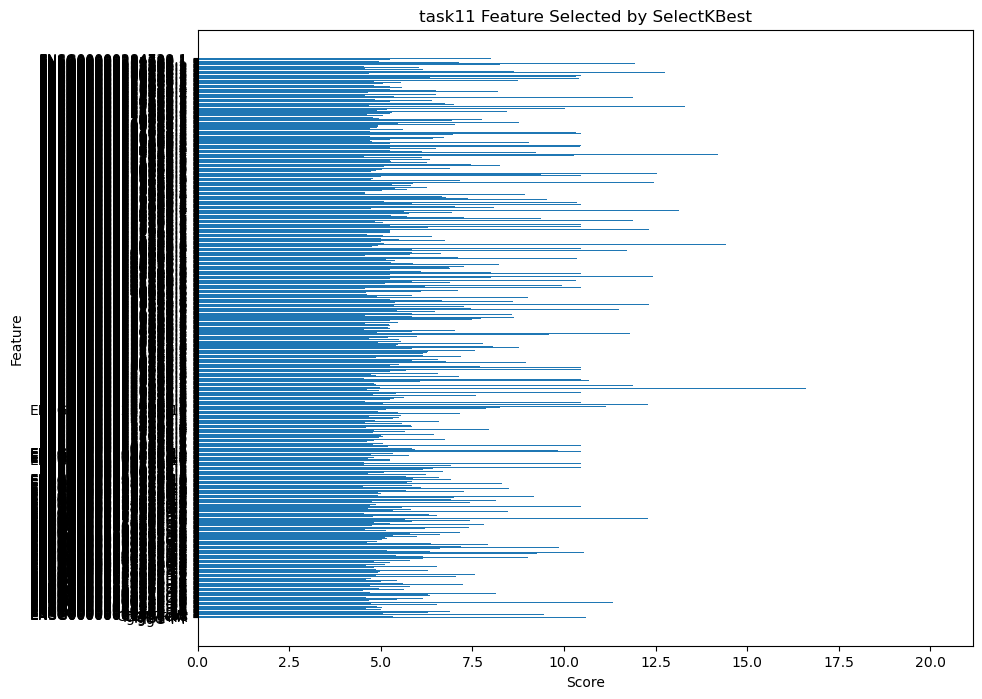

Best scaler: MinMaxScaler
Start tuning model: RandomForestRegressor()
Start tuning model: SVR()
Start tuning model: GradientBoostingRegressor()
Start tuning model: Lasso()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e-01, tolerance: 1.367e-01
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.388e+00, tolerance: 1.965e-01
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

Start tuning model: Ridge()
Start tuning model: ElasticNet()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.871e+01, tolerance: 1.367e-01
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.614e+01, tolerance: 1.919e-01
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

Start tuning model: DecisionTreeRegressor()
Start tuning model: KNeighborsRegressor()
Start tuning model: LinearRegression()
Start tuning model: Pipeline(steps=[('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('linear', LinearRegression())])
Start tuning model: SGDRegressor()
Start tuning model: BayesianRidge()
Start tuning model: ARDRegression()
Start tuning model: PassiveAggressiveRegressor()
Start tuning model: ExtraTreesRegressor()
Start tuning model: AdaBoostRegressor()
Start tuning model: BaggingRegressor()
Start tuning model: ExtraTreeRegressor()
Start tuning model: HuberRegressor()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

Start tuning model: QuantileRegressor()
Start tuning model: TheilSenRegressor()
Saved model evaluation metrics to CSV.


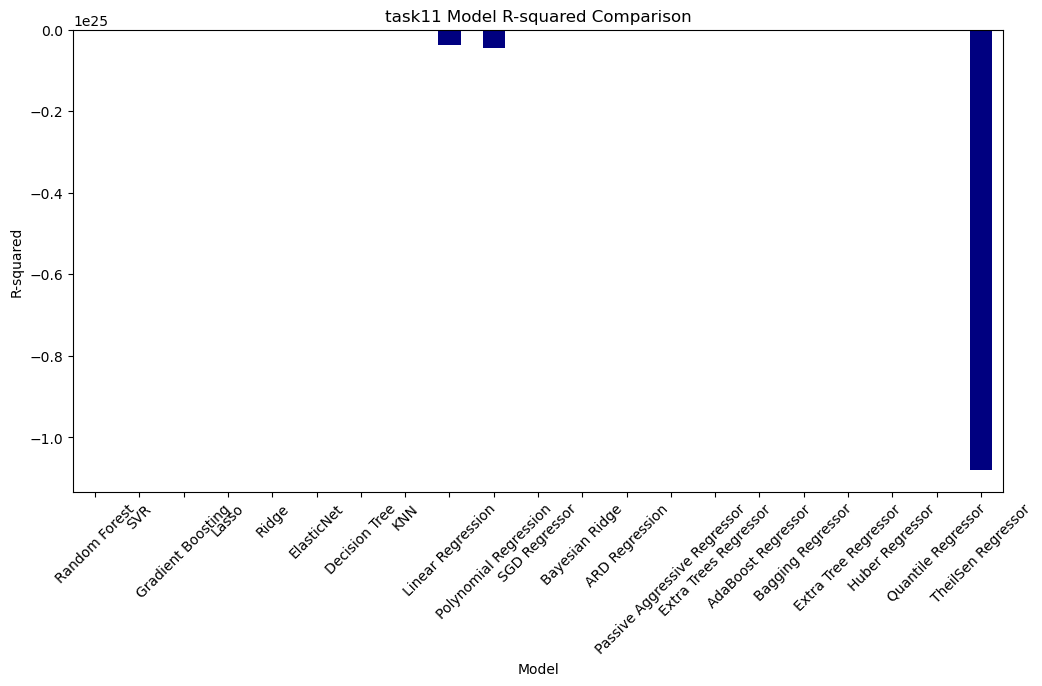

                                       MSE           MAE     R-squared  \
Model                                                                    
Random Forest                -1.803116e+01 -3.475673e+00  1.932440e-01   
SVR                          -1.007838e+01 -2.421688e+00  6.123279e-01   
Gradient Boosting            -1.680760e+01 -3.288432e+00  3.458474e-01   
Lasso                        -1.925458e+01 -3.522232e+00  2.504939e-01   
Ridge                        -1.100932e+01 -2.630365e+00  5.762541e-01   
ElasticNet                   -1.216814e+01 -2.763888e+00  5.278129e-01   
Decision Tree                -1.891939e+01 -3.307765e+00  2.738236e-01   
KNN                          -2.307393e+01 -3.757573e+00  9.787946e-02   
Linear Regression            -9.675998e+24 -2.084193e+12 -3.696355e+23   
Polynomial Regression        -1.178183e+25 -1.870941e+12 -4.613153e+23   
SGD Regressor                -1.096120e+01 -2.645777e+00  5.724517e-01   
Bayesian Ridge               -1.277029

In [4]:
train_model(df_train_task11, 'task11',True,'kbest',1000)

Feature selected by kbest:10


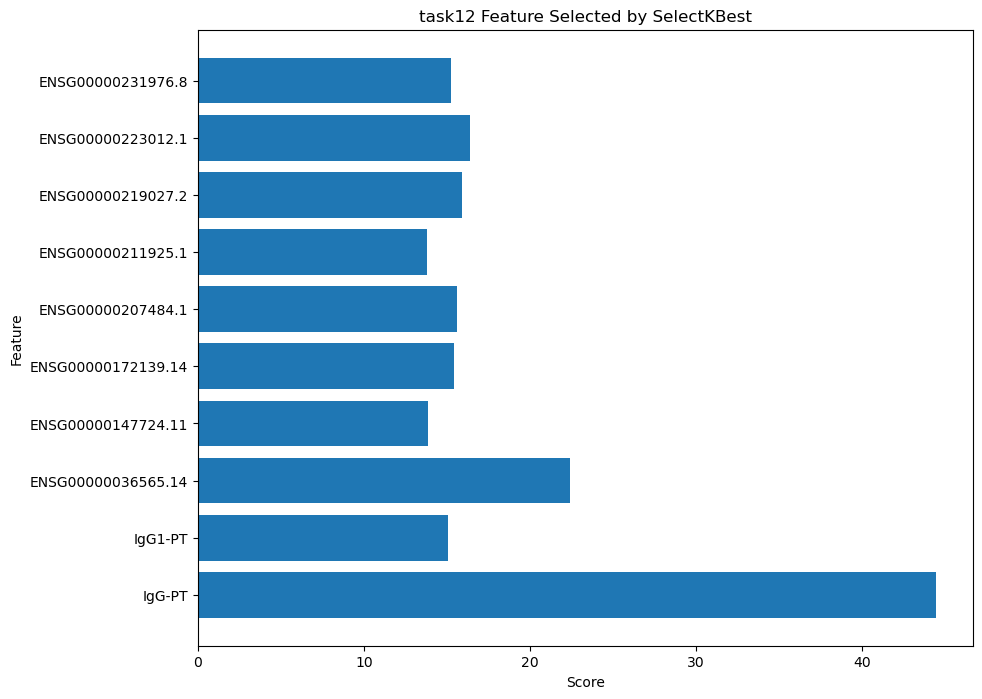

Best scaler: StandardScaler
Start tuning model: RandomForestRegressor()
Start tuning model: SVR()
Start tuning model: GradientBoostingRegressor()
Start tuning model: Lasso()
Start tuning model: Ridge()
Start tuning model: ElasticNet()
Start tuning model: DecisionTreeRegressor()
Start tuning model: KNeighborsRegressor()
Start tuning model: LinearRegression()
Start tuning model: Pipeline(steps=[('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('linear', LinearRegression())])
Start tuning model: SGDRegressor()
Start tuning model: BayesianRidge()
Start tuning model: ARDRegression()
Start tuning model: PassiveAggressiveRegressor()
Start tuning model: ExtraTreesRegressor()
Start tuning model: AdaBoostRegressor()
Start tuning model: BaggingRegressor()
Start tuning model: ExtraTreeRegressor()
Start tuning model: HuberRegressor()
Start tuning model: QuantileRegressor()
Start tuning model: TheilSenRegressor()
Saved model evaluation metrics

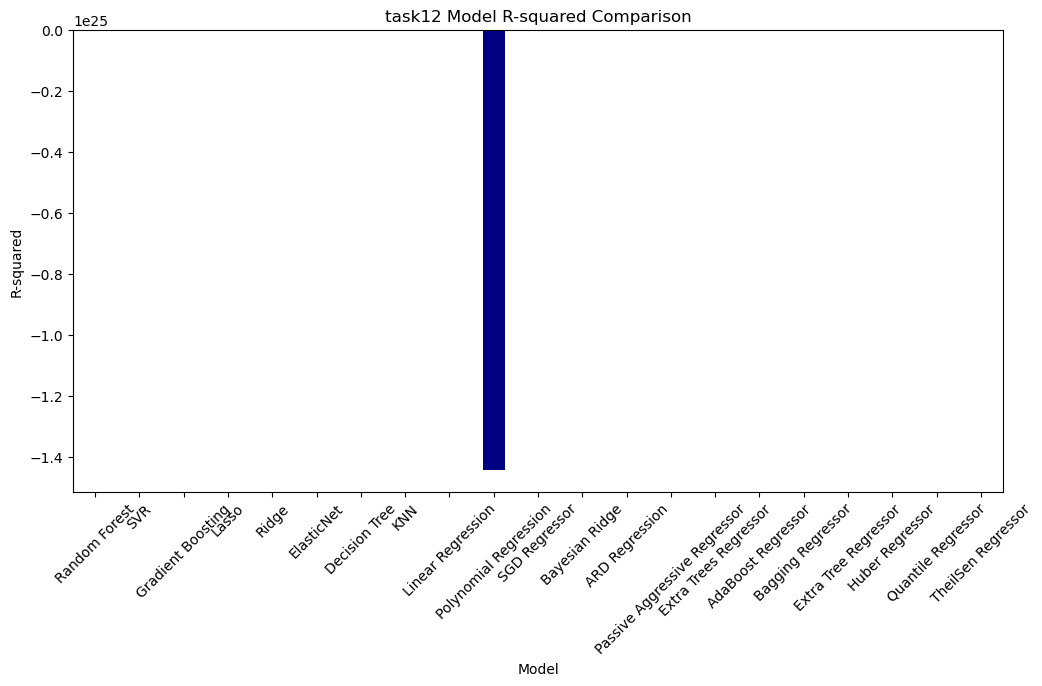

                                       MSE           MAE     R-squared  \
Model                                                                    
Random Forest                -9.636949e-01 -7.974977e-01  6.107118e-01   
SVR                          -1.220770e+00 -8.704310e-01  4.916112e-01   
Gradient Boosting            -9.029882e-01 -7.995203e-01  6.218734e-01   
Lasso                        -1.264205e+00 -9.205170e-01  4.777934e-01   
Ridge                        -1.345570e+00 -9.290860e-01  4.396712e-01   
ElasticNet                   -1.289618e+00 -9.237483e-01  4.652178e-01   
Decision Tree                -1.733110e+00 -1.046030e+00  2.868770e-01   
KNN                          -9.237138e-01 -8.032798e-01  6.126636e-01   
Linear Regression            -1.649651e+00 -1.025269e+00  3.087169e-01   
Polynomial Regression        -3.657268e+25 -1.293838e+12 -1.441951e+25   
SGD Regressor                -1.444075e+00 -9.720751e-01  3.955295e-01   
Bayesian Ridge               -1.324029

In [5]:
train_model(df_train_task12, 'task12',True,'kbest',10)

Feature selected by rf:20


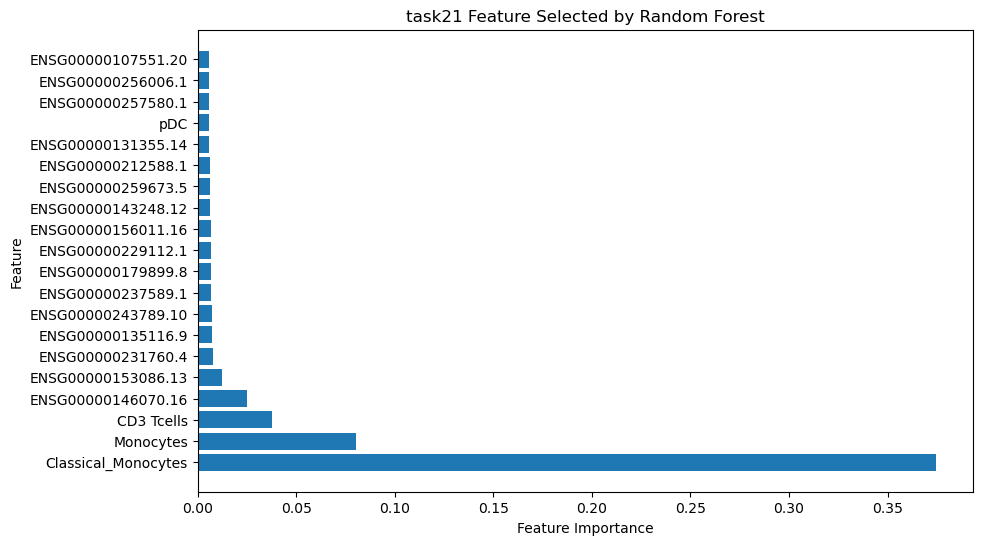

Start tuning model: RandomForestRegressor()
Start tuning model: SVR()
Start tuning model: GradientBoostingRegressor()
Start tuning model: Lasso()
Start tuning model: Ridge()
Start tuning model: ElasticNet()
Start tuning model: DecisionTreeRegressor()
Start tuning model: KNeighborsRegressor()
Start tuning model: LinearRegression()
Start tuning model: Pipeline(steps=[('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('linear', LinearRegression())])
Start tuning model: SGDRegressor()
Start tuning model: BayesianRidge()
Start tuning model: ARDRegression()
Start tuning model: PassiveAggressiveRegressor()
Start tuning model: ExtraTreesRegressor()
Start tuning model: AdaBoostRegressor()
Start tuning model: BaggingRegressor()
Start tuning model: ExtraTreeRegressor()
Start tuning model: HuberRegressor()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

Start tuning model: QuantileRegressor()
Start tuning model: TheilSenRegressor()
Saved model evaluation metrics to CSV.


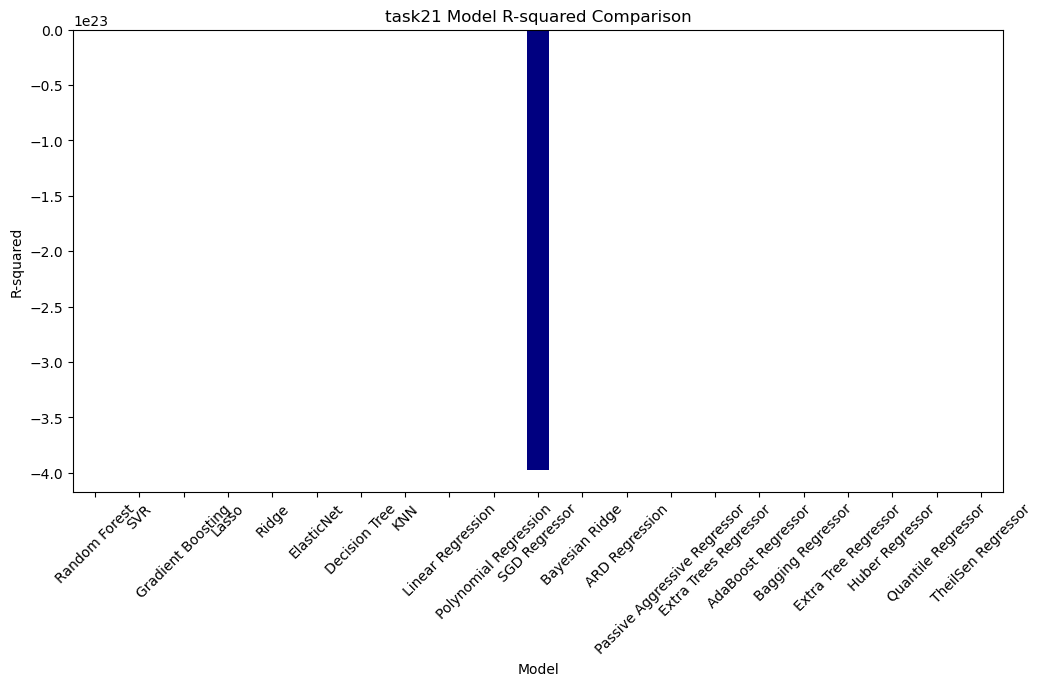

                                       MSE           MAE     R-squared  \
Model                                                                    
Random Forest                -4.672825e+01 -4.936763e+00  5.426403e-01   
SVR                          -5.310215e+01 -5.372808e+00  4.855213e-01   
Gradient Boosting            -4.002112e+01 -4.930992e+00  6.288876e-01   
Lasso                        -5.039085e+01 -5.578589e+00  4.661703e-01   
Ridge                        -4.432048e+01 -5.093064e+00  4.962416e-01   
ElasticNet                   -4.610165e+01 -5.333545e+00  5.010813e-01   
Decision Tree                -6.181586e+01 -6.414253e+00  3.402308e-01   
KNN                          -5.509461e+01 -5.446950e+00  4.521387e-01   
Linear Regression            -2.259100e+02 -1.125355e+01 -1.663369e+00   
Polynomial Regression        -3.729650e+02 -1.356795e+01 -2.357801e+00   
SGD Regressor                -5.256946e+25 -4.594317e+12 -3.971734e+23   
Bayesian Ridge               -4.379428

In [11]:
train_model(df_train_task21, 'task21',False,'rf',20)

Feature selected by rf:30


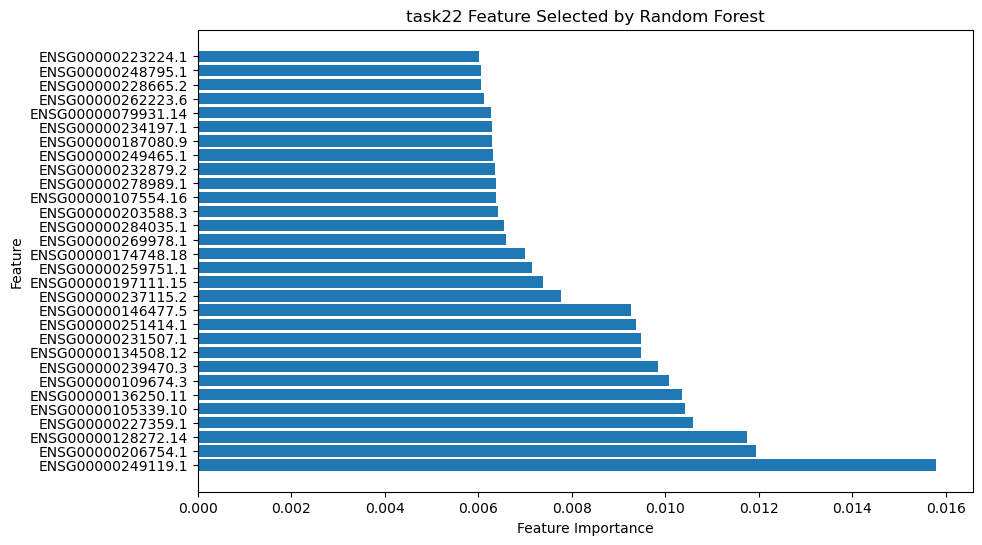

Best scaler: MinMaxScaler
Start tuning model: RandomForestRegressor()
Start tuning model: SVR()
Start tuning model: GradientBoostingRegressor()
Start tuning model: Lasso()
Start tuning model: Ridge()
Start tuning model: ElasticNet()
Start tuning model: DecisionTreeRegressor()
Start tuning model: KNeighborsRegressor()
Start tuning model: LinearRegression()
Start tuning model: Pipeline(steps=[('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('linear', LinearRegression())])
Start tuning model: SGDRegressor()
Start tuning model: BayesianRidge()
Start tuning model: ARDRegression()
Start tuning model: PassiveAggressiveRegressor()
Start tuning model: ExtraTreesRegressor()
Start tuning model: AdaBoostRegressor()
Start tuning model: BaggingRegressor()
Start tuning model: ExtraTreeRegressor()
Start tuning model: HuberRegressor()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

Start tuning model: QuantileRegressor()
Start tuning model: TheilSenRegressor()
Saved model evaluation metrics to CSV.


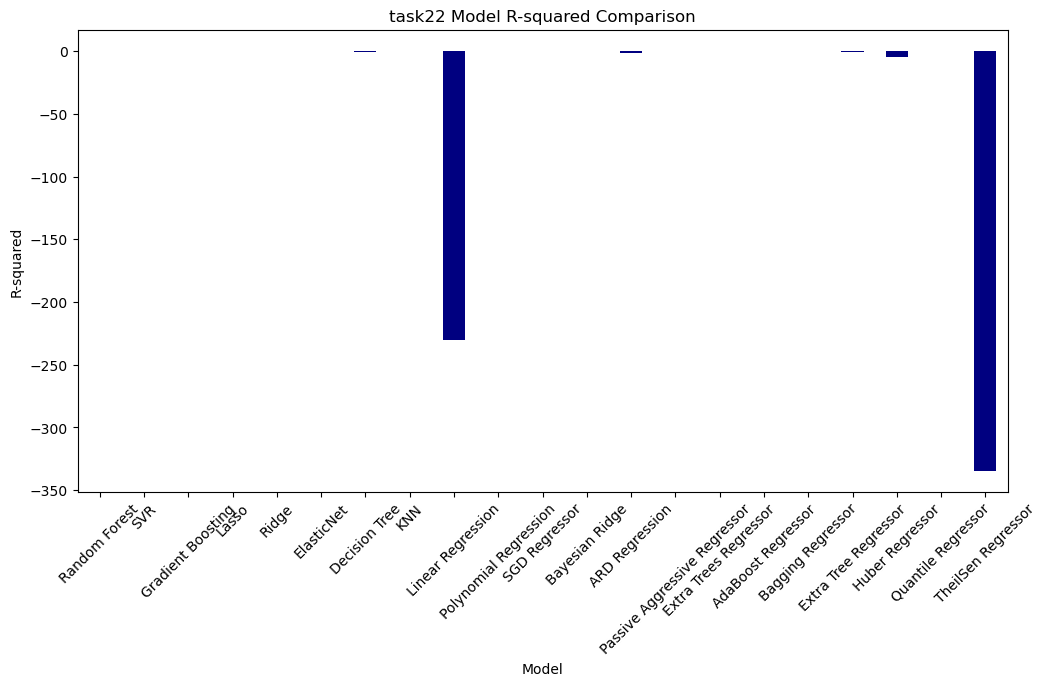

                                     MSE       MAE   R-squared  \
Model                                                            
Random Forest                  -0.158789 -0.311329   -0.057156   
SVR                            -0.153960 -0.279109    0.133616   
Gradient Boosting              -0.166085 -0.317415   -0.180274   
Lasso                          -0.118842 -0.257655    0.280965   
Ridge                          -0.086865 -0.220176    0.363876   
ElasticNet                     -0.072429 -0.201987    0.347544   
Decision Tree                  -0.223322 -0.415029   -0.779789   
KNN                            -0.155906 -0.316593   -0.136735   
Linear Regression             -78.070576 -4.222205 -230.237810   
Polynomial Regression          -0.136599 -0.270491    0.053519   
SGD Regressor                  -0.156810 -0.308506   -0.028811   
Bayesian Ridge                 -0.085204 -0.218478    0.270419   
ARD Regression                 -0.322552 -0.395162   -1.195214   
Passive Ag

In [7]:
train_model(df_train_task22, 'task22',True,'rf',30)

Feature selected by kbest:2000


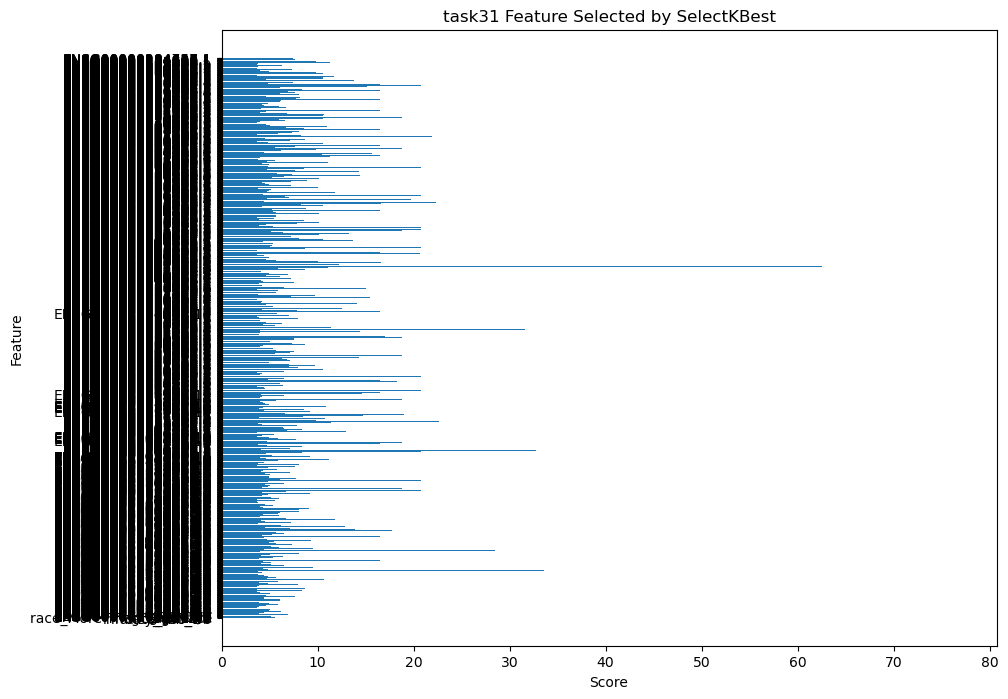

Best scaler: RobustScaler
Start tuning model: RandomForestRegressor()
Start tuning model: SVR()
Start tuning model: GradientBoostingRegressor()
Start tuning model: Lasso()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.308e+02, tolerance: 1.108e+02
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.882e+02, tolerance: 4.082e+02
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

Start tuning model: Ridge()
Start tuning model: ElasticNet()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e+02, tolerance: 1.108e+02
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e+02, tolerance: 1.108e+02
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

Start tuning model: DecisionTreeRegressor()
Start tuning model: KNeighborsRegressor()
Start tuning model: LinearRegression()
Start tuning model: Pipeline(steps=[('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('linear', LinearRegression())])
Start tuning model: SGDRegressor()
Start tuning model: BayesianRidge()
Start tuning model: ARDRegression()
Start tuning model: PassiveAggressiveRegressor()
Start tuning model: ExtraTreesRegressor()
Start tuning model: AdaBoostRegressor()
Start tuning model: BaggingRegressor()
Start tuning model: ExtraTreeRegressor()
Start tuning model: HuberRegressor()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

Start tuning model: QuantileRegressor()
Start tuning model: TheilSenRegressor()
Saved model evaluation metrics to CSV.


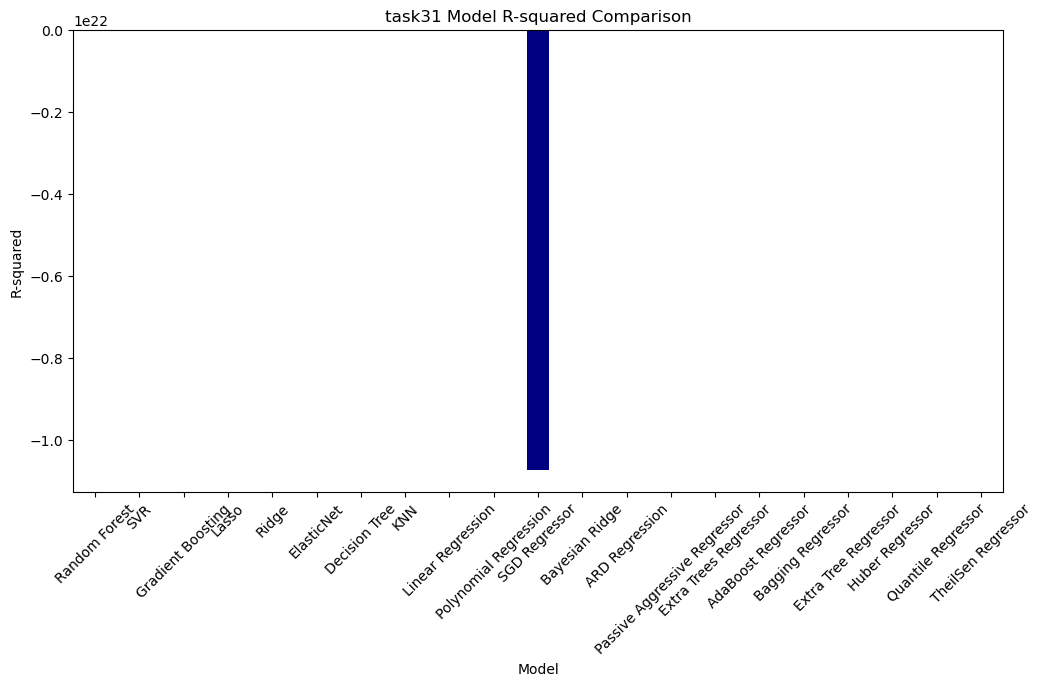

                                       MSE           MAE     R-squared  \
Model                                                                    
Random Forest                -7.235725e+04 -1.598691e+02 -7.811639e+01   
SVR                          -6.409091e+04 -1.075626e+02 -6.358456e-01   
Gradient Boosting            -9.002554e+04 -1.673271e+02 -1.144715e+02   
Lasso                        -6.130231e+04 -1.526562e+02 -2.036895e+01   
Ridge                        -5.306943e+04 -1.180401e+02 -4.124477e+00   
ElasticNet                   -5.405360e+04 -1.222861e+02 -5.217023e+00   
Decision Tree                -9.854327e+04 -1.943044e+02 -8.408874e+01   
KNN                          -6.317052e+04 -1.035716e+02 -1.486400e-01   
Linear Regression            -5.290648e+04 -1.171212e+02 -3.930660e+00   
Polynomial Regression        -3.172410e+04 -7.852889e+01  3.389758e-01   
SGD Regressor                -2.387110e+25 -3.535221e+12 -1.071532e+22   
Bayesian Ridge               -5.294889

In [8]:
train_model(df_train_task31, 'task31',True,'kbest',2000)

Feature selected by kbest:2000


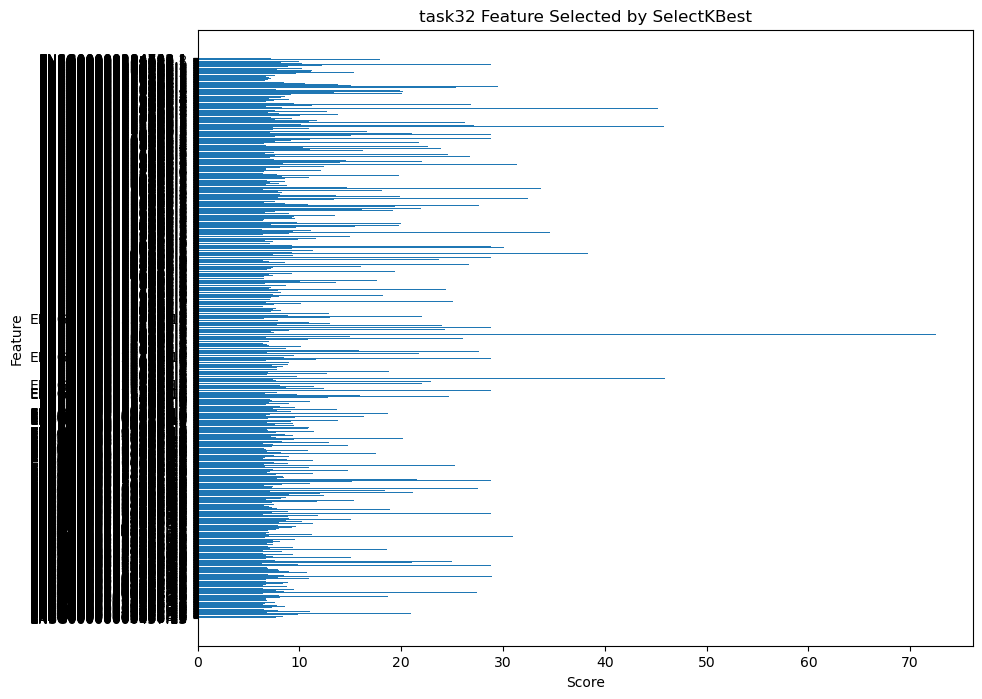

Best scaler: MinMaxScaler
Start tuning model: RandomForestRegressor()
Start tuning model: SVR()
Start tuning model: GradientBoostingRegressor()
Start tuning model: Lasso()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.338e-02, tolerance: 1.279e-02
  model = cd_fast.enet_coordinate_descent(


Start tuning model: Ridge()
Start tuning model: ElasticNet()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.120e-01, tolerance: 1.279e-02
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.720e-02, tolerance: 1.414e-02
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

Start tuning model: DecisionTreeRegressor()
Start tuning model: KNeighborsRegressor()
Start tuning model: LinearRegression()
Start tuning model: Pipeline(steps=[('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('linear', LinearRegression())])
Start tuning model: SGDRegressor()
Start tuning model: BayesianRidge()
Start tuning model: ARDRegression()
Start tuning model: PassiveAggressiveRegressor()
Start tuning model: ExtraTreesRegressor()
Start tuning model: AdaBoostRegressor()
Start tuning model: BaggingRegressor()
Start tuning model: ExtraTreeRegressor()
Start tuning model: HuberRegressor()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

Start tuning model: QuantileRegressor()
Start tuning model: TheilSenRegressor()
Saved model evaluation metrics to CSV.


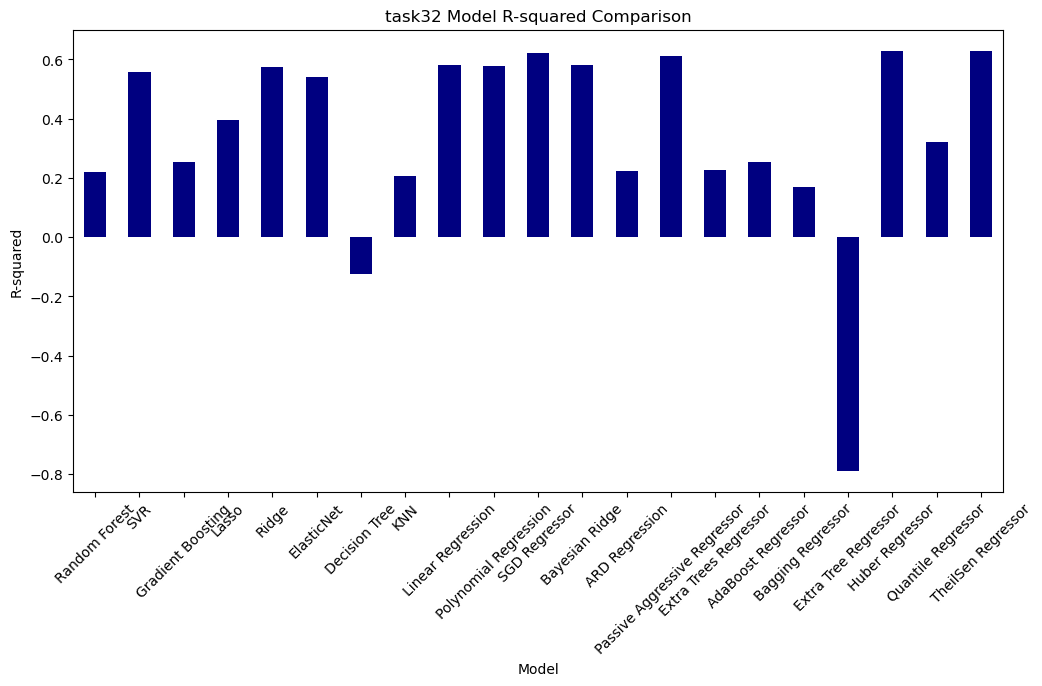

                                   MSE       MAE  R-squared  \
Model                                                         
Random Forest                -1.732749 -0.953484   0.220728   
SVR                          -0.916751 -0.715660   0.556101   
Gradient Boosting            -1.535989 -0.928498   0.255070   
Lasso                        -1.170805 -0.772053   0.395811   
Ridge                        -0.879468 -0.702543   0.573878   
ElasticNet                   -0.911575 -0.694531   0.540324   
Decision Tree                -3.599084 -1.281309  -0.124571   
KNN                          -1.797960 -0.944535   0.206671   
Linear Regression            -0.865519 -0.696408   0.582713   
Polynomial Regression        -0.872512 -0.720115   0.579162   
SGD Regressor                -0.817625 -0.671613   0.621463   
Bayesian Ridge               -0.865801 -0.696530   0.582665   
ARD Regression               -1.425435 -0.885490   0.223529   
Passive Aggressive Regressor -0.811346 -0.661247   0.61

In [9]:
train_model(df_train_task32, 'task32',True,'kbest',2000)